In [1]:
from erddapy import ERDDAP
from erddapy import utilities

In [2]:
import json
import urllib
import requests
file = urllib.request.urlopen('https://raw.githubusercontent.com/IrishMarineInstitute/search-erddaps/master/erddaps.json')
all_servers = json.loads(file.read())
file.getcode()

200

In [3]:
servers=all_servers[:3]

In [4]:
#servers=[{'url': 'https://cwcgom.aoml.noaa.gov/erddap/'}]

In [5]:
time_min = '2015-07-10T00:00:00Z'
time_max = '2016-08-10T00:00:00Z'
bbox = [-72.0, -69, 38, 41]

kw = {
   'search_for': 'all',
   'min_lon': bbox[0],
   'max_lon': bbox[1],
   'min_lat': bbox[2],
   'max_lat': bbox[3],
   'min_time': time_min,
   'max_time': time_max,
   'standard_name': 'depth'
}

In [6]:
import pandas as pd
all_datasets=pd.DataFrame()

for key in servers:
    url = key['url']
    url = url.rstrip("/")
    r = requests.get(url)
    try:
        r.raise_for_status()
        e = ERDDAP(
                 server=url,
                 protocol='tabledap',
                 response='csv'
           )
        print(e.get_search_url(**kw))
    except requests.exceptions.RequestException as err:
        print("Bad ERDDAP!!! {}".format(url))
    except requests.exceptions.HTTPError as errh:
        print("Bad ERDDAP!!! {}".format(url))
    except requests.exceptions.ConnectionError as errc:
        print("Bad ERDDAP!!! {}".format(url))
    except requests.exceptions.Timeout as errt:
        print("Bad ERDDAP!!! {}".format(url))
        
    ds = pd.read_csv('%s'%e.get_search_url(**kw))
    ds['server'] = url
    
    datasets = ds[['server','Dataset ID','tabledap']]
    
    datasets.dropna(subset=['tabledap'],inplace=True)
    
    all_datasets = pd.concat([all_datasets,datasets])

https://coastwatch.pfeg.noaa.gov/erddap/search/advanced.csv?page=1&itemsPerPage=1000&protocol=(ANY)&cdm_data_type=(ANY)&institution=(ANY)&ioos_category=(ANY)&keywords=(ANY)&long_name=(ANY)&standard_name=depth&variableName=(ANY)&minLon=-72.0&maxLon=-69&minLat=38&maxLat=41&minTime=1436486400.0&maxTime=1470787200.0&searchFor=all


/anaconda3/envs/erddap/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


https://apdrc.soest.hawaii.edu/erddap/search/advanced.csv?page=1&itemsPerPage=1000&protocol=(ANY)&cdm_data_type=(ANY)&institution=(ANY)&ioos_category=(ANY)&keywords=(ANY)&long_name=(ANY)&standard_name=depth&variableName=(ANY)&minLon=-72.0&maxLon=-69&minLat=38&maxLat=41&minTime=1436486400.0&maxTime=1470787200.0&searchFor=all
https://erddap.bco-dmo.org/erddap/search/advanced.csv?page=1&itemsPerPage=1000&protocol=(ANY)&cdm_data_type=(ANY)&institution=(ANY)&ioos_category=(ANY)&keywords=(ANY)&long_name=(ANY)&standard_name=depth&variableName=(ANY)&minLon=-72.0&maxLon=-69&minLat=38&maxLat=41&minTime=1436486400.0&maxTime=1470787200.0&searchFor=all


In [7]:
all_datasets.shape[0]

3

In [11]:
all_coords = pd.DataFrame()
for i in range(all_datasets.shape[0]):
    print(i)
    e2 = ERDDAP(
                 server=all_datasets['server'].iloc[int(i)],
                 protocol='tabledap',
                 response='csv'
           )
    e2.variables=["latitude","longitude","time"]
    e2.dataset_id = all_datasets['Dataset ID'].iloc[int(i)]
    #e2.constraints = kw
    e2.constraints = {
           "time>=": time_min,
           "time<=": time_max,
           "longitude>=": bbox[0],
           "longitude<=": bbox[1],
           "latitude>=": bbox[2],
           "latitude<=": bbox[3]
    }
    print(e2.get_download_url())
    df = e2.to_pandas()
    df['id'] = i
    all_coords = pd.concat([all_coords,df])
    #print(e.get_download_url(response="csv"))
    
    #dataset_url = '%s/tabledap/%s.csvp?latitude,longitude,time&longitude>=-72.0&longitude<=-69&latitude>=38&latitude<=41&time>=1278720000.0&time<=1470787200.0&distinct()' % (all_datasets['server'].iloc[int(i)],all_datasets['Dataset ID'].iloc[int(i)])
    #print(dataset_url)
    #coords = pd.read_csv(str(dataset_url))
    #all_coords = pd.concat([all_coords,coords])
    #print(coords) 
df

0
https://coastwatch.pfeg.noaa.gov/erddap/tabledap/scrippsGliders.csv?latitude,longitude&time>=1436486400.0&time<=1470787200.0&longitude>=-72.0&longitude<=-69&latitude>=38&latitude<=41
1
https://coastwatch.pfeg.noaa.gov/erddap/tabledap/erdGtsppBest.csv?latitude,longitude&time>=1436486400.0&time<=1470787200.0&longitude>=-72.0&longitude<=-69&latitude>=38&latitude<=41
2


HTTPError: 500 Server Error:  for url: https://erddap.bco-dmo.org/erddap/tabledap/bcodmo_dataset_549122.csv?latitude,longitude&time%3E=1436486400.0&time%3C=1470787200.0&longitude%3E=-72.0&longitude%3C=-69&latitude%3E=38&latitude%3C=41

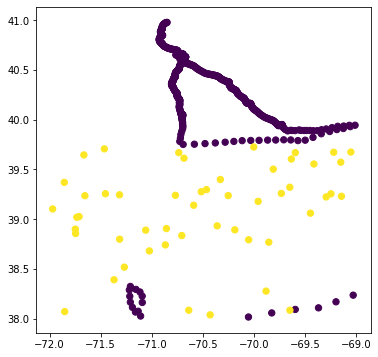

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6)) #make_map(extent, figsize=(6, 6))
#add_etopo2(extent, ax)
cs = plt.scatter(all_coords['longitude (degrees_east)'],
               all_coords['latitude (degrees_north)'],
               s=40, c=all_coords['id'].values)
#df.plot(x='longitude (degrees_east)',y='latitude (degrees_north)')

In [ ]:
# from erddapy import ERDDAP


# e = ERDDAP(
#   server='https://data.ioos.us/gliders/erddap',
#   protocol='tabledap',
# )

# e.response = 'csv'
# e.dataset_id = 'whoi_406-20160902T1700'
# e.constraints = {
#     'time>=': '2016-07-10T00:00:00Z',
#     'time<=': '2017-02-10T00:00:00Z',
#     'latitude>=': 38.0,
#     'latitude<=': 41.0,
#     'longitude>=': -72.0,
#     'longitude<=': -69.0,
# }
# e.variables = [
#     'depth',
#     'latitude',
#     'longitude',
#     'salinity',
#     'temperature',
#     'time',
# ]

In [ ]:
#     if url != 'http://erddap.emodnet-physics.eu/erddap' and \
#     url != 'https://erddap.marine.ie/erddap' and \
#     url != 'http://oos.soest.hawaii.edu/erddap' and \
#     url != 'http://erddap.secoora.org/erddap' and \
#     url != 'https://ecowatch.ncddc.noaa.gov/erddap' and \
#     url != 'http://dap.onc.uvic.ca/erddap':

In [ ]:
# laturl = 'http://erddap.bco-dmo.org/erddap/categorize/variableName/latitude/index.csv'
# lonurl = 'http://erddap.bco-dmo.org/erddap/categorize/variableName/longitude/index.csv'

# df_lat = pd.read_csv(laturl, header=[0])
# df_lon = pd.read_csv(lonurl, header=[0])

# df_datasets = pd.merge(df_lat, df_lon, on='Dataset ID')
# df_final = pd.DataFrame(columns=['latitude (degrees_north)', 'longitude (degrees_east)', 'Dataset ID'])

# for did in df_datasets['Dataset ID']:
#     if did != 'bcodmo_dataset_739309': # remove this once we reload all the datasets again.
#         dataset_url = 'http://erddap.bco-dmo.org/erddap/tabledap/%s.csvp?latitude,longitude&distinct()' % did
#         df_data = pd.read_csv(dataset_url, header=0, usecols=['latitude (degrees_north)', 'longitude (degrees_east)'])
#         df_data['Dataset ID'] = did
#         df_final = pd.concat([df_final, df_data], sort=False, ignore_index=True)
#         print(df_final.shape)

# lon = df_final['longitude (degrees_east)'].values
# lat = df_final['latitude (degrees_north)'].values